In [17]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
import string
import matplotlib.pyplot as plt
from datetime import datetime
#sklearn realted
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
#Theme
jtplot.style()

#setting the correct working directory
os.chdir("/home/willinki/DATA-SCIENCE-1/data-semantics/Just-News/1_ScoreInduction")

# Open the pre-prepared lexicon
with open("../lexicon/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

# Score induction - Nicoli Method
## Model tuning
We use a support vector machine, with parameters tuned via cross validation.

We observe that a value of C of around 5 seems to be the best.

[]

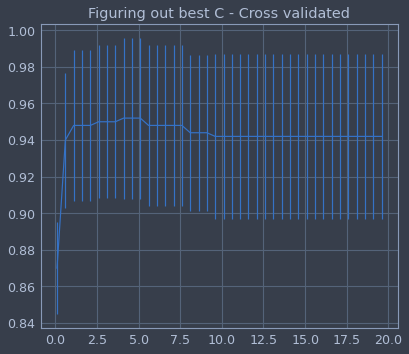

In [18]:
#####################################################
# X contains vector components                      #
# Y contains labels                                 #
#####################################################
X = enriched_lexicon["Vectorized_words"].tolist()
y = enriched_lexicon["Labels"]

#to store the accuracy on cross validation
score_mean = []
score_stds = []

#range of C values 
Cs = np.arange(0.1, 20, 0.5)

#cross-validation varying c
for c in Cs:
    clf = svm.SVC(C=c, kernel = "poly", gamma="auto")
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

#plot
plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.title("Figuring out best C - Cross validated")
plt.plot()

## Prediction of lables of the two models

In [19]:
#loading models and selecting
slices = {
          filename.split('/')[-1].replace(".model", "") : 
          Word2Vec.load(filename)
          for filename in glob.glob('../models/*.model')
         }

##########################################################
# SELECT WHICH MODELS YOU WANT TO USE                    #
##########################################################
model_names = ["New York Times", "Breitbart"]
##########################################################

models = [slices[name] for name in model_names]

#training model with hyperparameters
inducer = svm.SVC(C = 5, kernel = 'poly', gamma='auto').fit(X,y)

#propagating
#this will contain all the annotated vocabularies
annotated_vocabs = {}

for model, model_name in zip(models, model_names):
    #add empty vocabulary for model
    annotated_vocabs[model_name] = {}

    for word in model.wv.vocab:
        word_vector = model.wv[word]
        label = inducer.predict([word_vector])[0]

        #add to the annotated vocab
        annotated_vocabs[model_name][word] = label

`annotated_vocabs` has the following shape:
```
{
    <model1> : {
                    <word1> : +-1
                    <word2> : +-1
                    ...
                    ...
               }
    <model2> : {
                    <word1> : +-1
                    <word2> : +-1
                    ...
                    ...
               }
}
```

## Saving the annotated vocabs

In [20]:
#changing directory
os.mkdir("../annotated_vocabs")
dest_dir = os.chdir("../annotated_vocabs")

#giving a long but explanatory name
time = datetime.now().strftime(format = "%m-%d-%H:%M")
file_names = [
                "{}-Nicoli-{}.json".format(model_name, time)
                for model_name in model_names
             ]

for file_name, model_name in zip(file_names, model_names):
    with open(file_name, 'w+') as outfile:
        json_output = json.dumps(annotated_vocabs[model_name])
        outfile.write(json_output)

#ok.. i'm coming back
os.chdir("/home/willinki/DATA-SCIENCE-1/data-semantics/Just-News/1_ScoreInduction")